## 1. Data
#### 1.1. Input Data
The data "characteristics.csv" contains US public firms' characteristics that are related to leases. They are averaged across the 3-year period from 2016 to 2018.

#### 1.2. Output data
The code will output a list of companies along with a cluster assignment.

#### 1.3. Feature (i.e., variable) definition. For details, see <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon (2022)</a>.
- *lag_lease*: prior year's lease activity<br>
- *lag_market_value*: prior year's market capitalization of the stock<br>
- *lag_dividend*: an indicator value that equals 1 if the company paid any dividends in the prior, and 0 otherwise<br>
- *lag_loss*: an indicator value that equals 1 if the company reported negative profits in the prior year<br>
- *lag_cash*: prior year's cash balance<br>
- *lag_tax_rate*: effective tax rate in the prior year<br>
- *lag_big4_auditor*: an indicator value that equals 1 if the company hired a Big 4 auditor in the prior year<br>

## 2. Implementing K-means clustering in Python (Scikit-learn)


### 2.1. Preparation


In [13]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA

In [14]:
# Import the csv file
characteristics = pd.read_csv('characteristics.csv')

### 2.2. Conduct an Exploratory Data Analysis (EDA)

#### 2.2.1. Show the first 5 entries in the data

In [15]:
# First 5 entries
characteristics.head()

,identifier,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
0,1004,1.566298,6.926615,0.007283,0.0,0.021530,0.359131,1.0
1,1050,0.810631,5.635750,0.016376,1.0,0.076807,0.350014,0.0
2,1072,0.194303,7.785037,0.028557,0.0,0.394580,0.167300,1.0
3,1078,0.320986,11.183587,0.030134,0.0,0.210340,0.371148,1.0
4,1104,1.091098,4.292186,0.014084,0.0,0.058464,0.342861,0.0


#### 2.2.2. The # of variables and entries
There are a total of 8 variables = 1 identifier + 7 firm features anda total of 1640 entries, which are all unique firm entries.

In [16]:
# (Number of entries, Number of features)
print(characteristics.shape)

# The number of unique firms
print(characteristics['identifier'].nunique())

(1640, 8)
1640


#### 2.2.3. Remove identifiers
Because I don't need the identifier column for this analysis, I will create a new dataframe without it.

In [17]:
# Create a sample to conduct the analysis
sample = characteristics.drop(columns=['identifier'])

#### 2.2.4. Descriptive stats (empirical distributions, histograms, and correlation plots)
A few observations:
- There are no missing values (all counts equal 1640).<br>
- Features do not have outliers. This is important because one of the disadvantages of K-means clustering is that centroids can be significantly affected by outliers instead of being ignored.
- *lag_lease*,  *lag_dividend*, *lag_cash* are right-skewed, which make economic sense.<br>
- *lag_market_value* follows a normal distribution.<br>
- The *lag_tax_rate* values are clustered around 35%.<br>

In summary, this is clean data with values that make economic sense.

For simplicity, I do not provide a detailed explanation of the data. 
See <a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon (2022)</a> for more details. 


In [18]:
# Show empirical distributions
sample.describe()

,lag_lease,lag_market_value,lag_dividend,lag_loss,lag_cash,lag_tax_rate,lag_big4_auditor
count,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000
mean,1.786803,7.542243,0.016611,0.259045,0.204958,0.276199,0.815752
std,2.642125,1.730802,0.027882,0.382068,0.226048,0.108693,0.381615
min,0.032784,3.697241,0.000000,0.000000,0.000878,0.000101,0.000000
25%,0.466649,6.387482,0.000000,0.000000,0.047117,0.232194,1.000000
50%,0.874767,7.455973,0.001367,0.000000,0.119014,0.349967,1.000000
75%,1.824188,8.653680,0.023156,0.333333,0.272314,0.350238,1.000000
max,15.683336,12.116967,0.172973,1.000000,0.959124,0.372000,1.000000


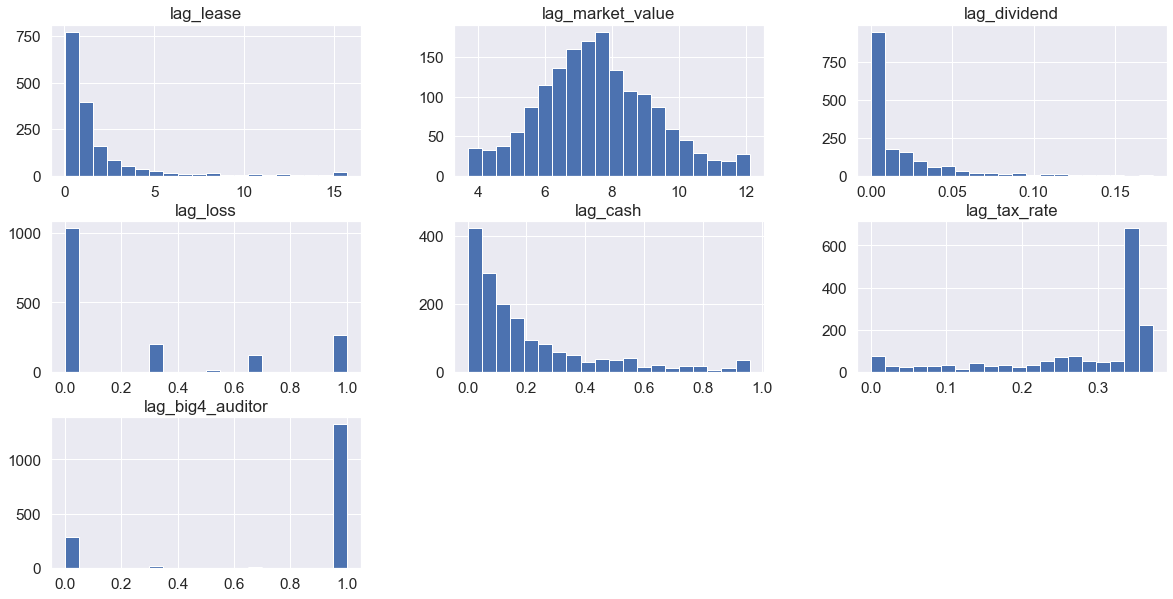

In [19]:
# Show histograms
sample.hist(bins = 20, figsize =(20, 10))
plt.show()


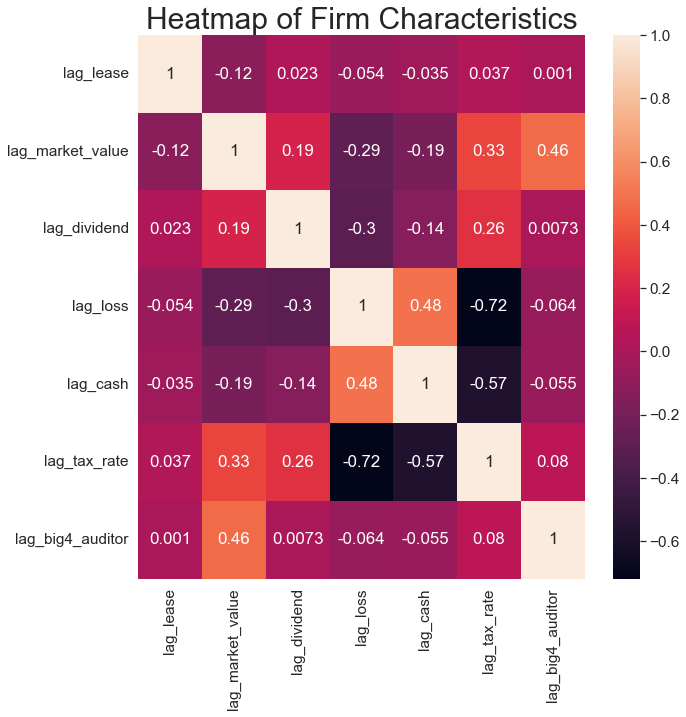

In [20]:
# Plot correlation heatmap
correlations = sample.corr()                                # Compute correlations
f, ax = plt.subplots(figsize=(10,10))                       # Figure size
sns.heatmap(correlations, annot=True)                       # Create a heatmap
sns.set(font_scale=1.4)                                     # Font size
plt.title('Heatmap of Firm Characteristics', fontsize = 30) # Title
plt.show()

### 2.3. K-Means Clustering
#### 2.3.1. Feature engineering - Standardizing  the features
Because I want to minimize within-cluster euclidean distances, it is important to standardize features first.


In [21]:
# Standardize features
sample_scaled = StandardScaler().fit_transform(sample)

#### 2.3.2. The Elbow Method

One disadvantage of K-means clustering is that we have to choose k manually. But we can choose k intellectually by using the Elbow method, one of the most popular and effective methods.

In the Elbow method, we are going to gradually increase k from 1 and plot inertia across k. Inertia refers to the within-cluster sum of squared distances from centroids. As shown in the figure below, the line resembles an arm. Starting at around k=4, we can see that the line flattens out. In other words, k=4 seems to be the "elbow point". In my dissertation, I use k=4, 6, and 8  to ensure that my results are not sensitive to the choice of k. 

#### 2.3.3. K-Means++
The second disadvantage of K-means clustering is that it depends on the initial values of centroids. If you run the following code a couple of times, you will notices that the lines change slightly because the algorithm can end up at a local optimum. To overcome this challenge, we can use K-Means++. Unlike K-means that randomly select all of k centroids' initial points, K-Means++ randomly selects the first centroid point and selects the next centroid as the data point that has the maximum distance from the nearest centroid. This algorithm repeats until k centroids have been selected. The main idea is to select centroids that are far away from one another so that centroids are more likely to be located in different clusters.


C:\Users\Young\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


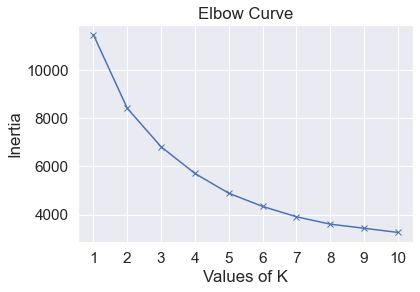

In [22]:
# Initialize inertia
inertia = []

# Calculate inertia for k=[1:10]
for i in range(1,11):                # i ranges from 1 to 10
    kmeans = KMeans(n_clusters = i,  # Assign i number of clusters
                    init='k-means++',# Use K-Means++ initialization
                    max_iter=1000)   # Set maximum # of iterations
    kmeans.fit(sample_scaled)        # Fitting the k means algorithm
    inertia.append(kmeans.inertia_)  # Record inertia
    
# Plot the inertia across k
plt.plot(inertia, 'bx-')
plt.xticks(list(range(0,10)),list(range(1,11)))   # Change the x ticks from 0:8 to 0:9
plt.xlabel('Values of K') 
plt.ylabel('Inertia')        
plt.title('Elbow Curve')    
plt.show()


#### 2.3.4. Implement K-means clustering
Now that we have chosen to use K=4 clusters, we can implement K-means clustering and group firms.

In [23]:
# Select k=4
kmeans = KMeans(n_clusters = 4,       # Assign i number of clusters
                    init='k-means++', # Use K-Means++ 
                    max_iter=1000)    # Set the max # of iterations

# fitting the k means algorithm
kmeans.fit(sample_scaled)

# Get cluster assignemnts
labels = kmeans.labels_

### 2.4. Principal Component Analysis (PCA) - Visualize Clusters
Before I export the cluster assignments and use them to conduct fixed effects analysis, I visualize clusters by conducting a principal component analysis.

#### 2.4.1. Conduct PCA
It is very difficult to visualize seven features. To better visualize the 7-dimensional data, I will first reduce it to 2-dimensional data in the following code.

In [24]:
# Add identifiers and cluster assignments (labels) to the sample
sample = pd.concat([characteristics['identifier'], sample, pd.DataFrame({'cluster':labels})], axis=1)

# Set the number of components
pca = PCA(n_components=2)

# Conduct dimentionality reduction
principal_comp = pca.fit_transform(sample_scaled)

# Create a dataframe and add a column of labels 
pca_df = pd.DataFrame(data = principal_comp, 
                      columns = ['principal_component1', 
                                 'principal_component2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'Cluster':labels})], 
                    axis = 1)      
# Show the first 5 firms
pca_df.head()

,principal_component1,principal_component2,Cluster
0,-0.990592,0.261629,3
1,1.170472,1.843412,2
2,0.316073,-0.778761,3
3,-1.778196,-1.366739,3
4,0.097569,2.826009,2


#### 2.4.2. Plot the two principal components
The following code plots the two principal components. Note that each component does not have a particular meaning.

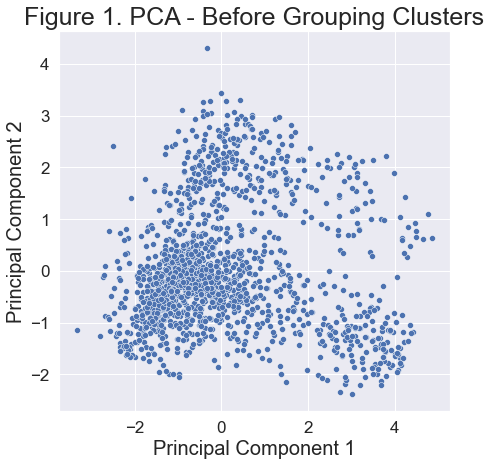

In [97]:
# Create a scatter plot of two components
plt.figure(figsize=(7,7))                                         # figure size
ax = sns.scatterplot(
    x="principal_component1", y="principal_component2",                    
    data = pca_df)                                                # plot
plt.xlabel("Principal Component 1", size=20)                      # x label
plt.ylabel("Principal Component 2", size=20)                      # y label
plt.xticks(fontsize=17)                                           # x tick
plt.yticks(fontsize=17)                                           # y tick
plt.title("Figure 1. PCA - Before Grouping Clusters", size=25)    # title
plt.show()

#### 2.4.3. Show clusters
Using the cluster assignments, we can group the points in clusters. Let's visualize them.

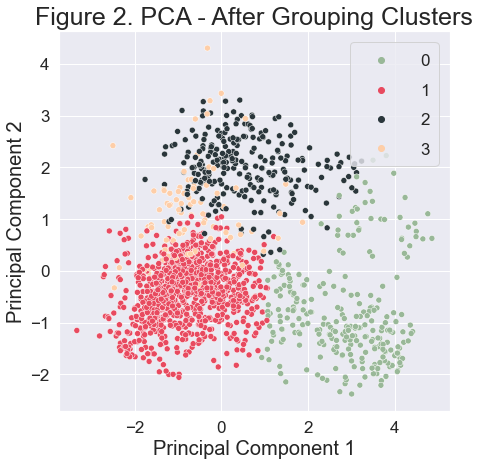

In [102]:
# Create a scatter plot of two components and group them into clusters
plt.figure(figsize=(7,7))                                      # figure size
ax = sns.scatterplot(
    x="principal_component1", y="principal_component2",                    
    hue = "Cluster", 
    data = pca_df, 
    palette = ['#99B898', '#E84A5F', '#2A363B', '#FECEA8'])     # Scatter Plot
plt.legend(loc='upper right')                                   # Legend position
plt.setp(ax.get_legend().get_texts(), fontsize='17')            # legend text
plt.setp(ax.get_legend().get_title(), fontsize='17')            # legend title
plt.xlabel("Principal Component 1", size=20)                    # x label
plt.ylabel("Principal Component 2", size=20)                    # y label
plt.xticks(fontsize=17)                                         # x tick
plt.yticks(fontsize=17)                                         # y tick
plt.title("Figure 2. PCA - After Grouping Clusters", size=25)   # Figure title
plt.show()


### 2.5. Export to csv
We are almost done. I am going to use the cluster assignments to form fixed effects. To do so, I export the sample and conduct regression analysis. The results can be found in my dissertation (<a href="https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3689446">Yoon 2022</a>).

In [208]:
# Export the sample as a csv file
sample.to_csv('characteristics_with_clusters.csv')